In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# used to load matlab file
from scipy import io

# minimize funtion to obtain the optimized theta
from scipy import optimize

# used to fit more complex regression
from sklearn import preprocessing

## Regularized Linear Regression

#### Dataset

In [2]:
data = io.loadmat('ex5/ex5data1.mat')
type(data)

dict

In [3]:
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])


In [4]:
# training set
X_train, y_train = data['X'], data['y']
X_train = np.insert(X_train, 0, 1, axis=1)  # add bias unit
print('shape: X_train = {} , y_train = {}'.format(X_train.shape, y_train.shape))

# cross validation set
X_val, y_val = data['Xval'], data['yval']
X_val = np.insert(X_val, 0, 1, axis=1)  # add bias unit
print('shape: X_val = {} , y_val = {}'.format(X_val.shape, y_val.shape))

# test set
X_test, y_test = data['Xtest'], data['ytest']
X_test = np.insert(X_test, 0, 1, axis=1)  # add bias unit
print('shape: X_test = {} , y_test = {}'.format(X_test.shape, y_test.shape))

shape: X_train = (12, 2) , y_train = (12, 1)
shape: X_val = (21, 2) , y_val = (21, 1)
shape: X_test = (21, 2) , y_test = (21, 1)


In [5]:
def plotData(x_data, y_data, x_label, y_label):
    plt.figure(facecolor='w')
    plt.scatter(x_data[:, 1], y_data, marker='x', color='r', label='Training data')
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.legend()

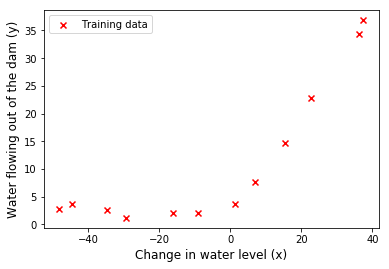

In [6]:
plotData(X_train, y_train, 'Change in water level (x)', 'Water flowing out of the dam (y)')

#### Cost Function and Gradient with Regularization

In [7]:
# linear hypothesis
def h(theta, X):
    hypothesis = np.dot(X, theta)
    return (hypothesis)

In [8]:
# cost function
def computeCostReg(theta, X, y, lambdaConst):
    m = y.size
    reg_term = (lambdaConst/2/m) * np.sum(theta[1:]**2)  # should not regularize the θ0 term.
    J = (1/2/m) * (np.sum((h(theta, X) - y)**2)) + reg_term
    return (J)

In [9]:
# gradient
def computeGradReg(theta, X, y, lambdaConst):
    m = y.size
    reg_term = (lambdaConst/m) * theta
    reg_term[0] = 0  # should not regularize the θ0 term.
    grad = (1/m) * np.dot(X.T, (h(theta, X) - y)) + reg_term
    return (grad.reshape(-1, 1))

def computeGradRegFlatten(theta, X, y, lambdaConst):
    """
    This function is for 'fprime' argument in scipy.optimize.fmin_cg. 
    fprime : A function that returns the gradient of f at x. The returned value must be a 1-D array.
    """
    return (computeGradReg(theta, X, y, lambdaConst).flatten())

In [10]:
# theta is a vector with n rows and 1 column (if X has n-1 feature, X0 is added)
theta_init = np.ones([X_train.shape[1], 1])  # use theta initialized at [1; 1]
print('cost = {}'.format(computeCostReg(theta_init, X_train, y_train, lambdaConst=1)))
print('gradient = \n{}'.format(computeGradReg(theta_init, X_train, y_train, lambdaConst=1)))

cost = 303.9931922202643
gradient = 
[[ -15.30301567]
 [ 598.25074417]]


#### Fitting the Linear Regression

In [11]:
def optimizeThetaReg(theta, X, y, lambdaConst, convergence_message):
    """
    Minimize a function using a nonlinear conjugate gradient algorithm to return the optimized theta.
    https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.optimize.fmin_cg.html
    """
    result = optimize.fmin_cg(computeCostReg, x0=theta, args=(X, y.ravel(), lambdaConst),
                              fprime=computeGradRegFlatten, maxiter=2000, disp=convergence_message)
    return (result.reshape(-1, 1))

In [12]:
theta_init = np.zeros([X_train.shape[1], 1])
theta_opt = optimizeThetaReg(theta_init, X_train, y_train, lambdaConst=0, convergence_message=True)
theta_opt

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5


array([[ 13.08790351],
       [  0.36777923]])

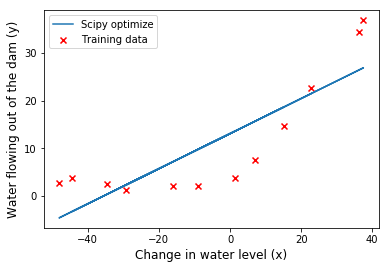

In [13]:
plotData(X_train, y_train, 'Change in water level (x)', 'Water flowing out of the dam (y)')
plt.plot(X_train[:, 1], h(theta_opt, X_train), label='Scipy optimize')
plt.legend()

## Bias-Variance

In [14]:
def plotLearningCurve(X_train, y_train, X_val, y_val, lambdaConst):
    """
    1. Observe the error on training and validation sets as the number of examples increases.
    2. When computing the training set error, compute it on the training subset (not the entire training set).
    3. For the cross validation error, compute it over the entire cross validation set.
    4. Learn the θ parameters, then, compute the error on the training and cross validation sets.
    5. Note that the training error does not include the regularization term (set λ to 0).
    """
    m = y_train.size
    error_train = []
    error_val = []
    theta_init = np.zeros([X_train.shape[1], 1])  # initial θ
    for i in range(1, m+1):
        theta_opt = optimizeThetaReg(theta_init, X_train[:i], y_train[:i], lambdaConst,
                                     convergence_message=False)  # learn θ parameters
        error_train.append(computeCostReg(theta_opt, X_train[:i], y_train[:i], lambdaConst))  # use subset
        error_val.append(computeCostReg(theta_opt, X_val, y_val, lambdaConst))  # use entire set

    # plot the learning curve
    plt.figure(figsize=(8,5), facecolor='w')
    plt.plot(np.arange(m)+1, error_train, label='Training set')
    plt.plot(np.arange(m)+1, error_val, label='Cross-Validation set')
    plt.title('Learning curve for linear regression', fontsize=15)
    plt.xlabel('Number of training examples', fontsize=15)
    plt.ylabel('Error', fontsize=15)
    plt.legend()

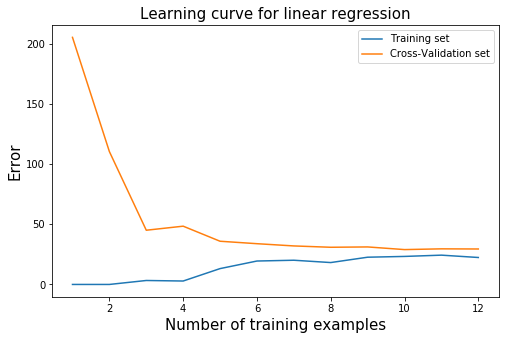

In [15]:
plotLearningCurve(X_train, y_train, X_val, y_val, lambdaConst=0)

## Polynomial Regression

#### Polynomial Features

In [16]:
# poly-features maps X (1D vector) into the p-th power
# since X_train has only one feature X1, the degree-p polynomial features are [1, X1, X1^2, X1^3,...,X1^p]
# This function adds bias unit automatically.
poly = preprocessing.PolynomialFeatures(degree=8, include_bias=True)
X_train_poly = poly.fit_transform(data['X'])

#### Feature Scaling

In [17]:
# since polynomial of degree 8, feature standardization is needed to train θ
def featureScaling(X):
    standard = preprocessing.StandardScaler()
    X_mu = standard.fit(X).mean_
    X_std = np.sqrt(standard.fit(X).var_)
    X_scaling = standard.fit_transform(X)
    # after fit_transform, the first column becomes zero, so re-add bias unit into the first column
    X_scaling[:, 0] = 1.
    return (X_scaling, X_mu, X_std)

In [18]:
X_train_polyScale = featureScaling(X_train_poly)[0]

#### Learning $\theta$ for Polynomial Regression (Adjusting the regularization parameter)

In [20]:
# use feature scaling polynomial training set to train θ (based on different lambda parameter)
theta_poly_init = np.zeros([X_train_polyScale.shape[1], 1])
lambda_para = [0, 1, 100]
theta_poly_opt = []
for i in lambda_para:
    theta_poly_opt.append(optimizeThetaReg(theta_poly_init, X_train_polyScale, y_train, lambdaConst=i,
                                           convergence_message=True))

Optimization terminated successfully.
         Current function value: 0.028890
         Iterations: 451
         Function evaluations: 888
         Gradient evaluations: 888
Optimization terminated successfully.
         Current function value: 6.830463
         Iterations: 34
         Function evaluations: 62
         Gradient evaluations: 62
Optimization terminated successfully.
         Current function value: 65.950955
         Iterations: 9
         Function evaluations: 17
         Gradient evaluations: 17


#### Plot Fit

In [21]:
# plot a range slightly bigger than the min and max values of training set
points = np.arange(min(data['X'])-3, max(data['X'])+5, 0.05).reshape(-1, 1)
points_poly = poly.fit_transform(points)
points_polyScale = featureScaling(points_poly)[0]

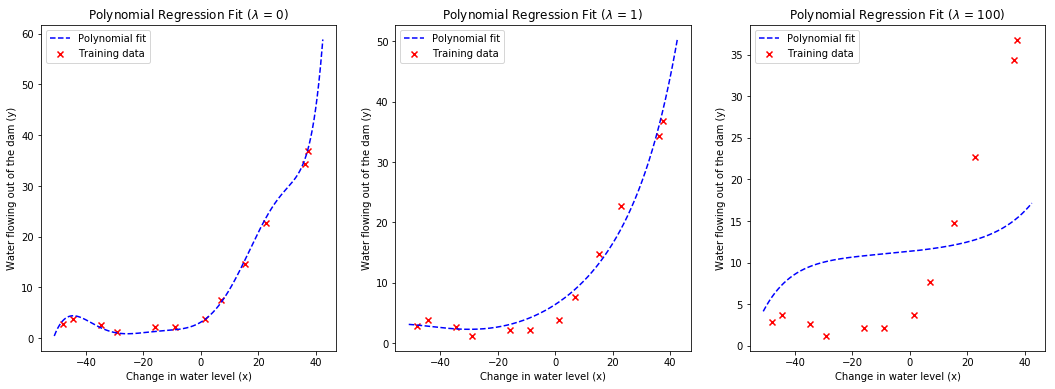

In [22]:
plt.figure(figsize=(18,6), facecolor='w')
for i, C in enumerate(lambda_para):
    plt.subplot(1, len(lambda_para), i+1)
    plt.scatter(X_train[:, 1], y_train, marker='x', color='r', label='Training data')
    plt.xlabel('Change in water level (x)', fontsize=10)
    plt.ylabel('Water flowing out of the dam (y)', fontsize=10)
    plt.plot(points, h(theta_poly_opt[i], points_polyScale), 'b--', label='Polynomial fit')
    plt.title('Polynomial Regression Fit ($\lambda$ = %i)'%(C))
    plt.legend()

#### Learning Curve for Polynomial Regression

In [23]:
def plotPolyLearningCurve(X_train_polyScale, y_train, X_val, y_val, lambdaConst=lambda_para):
    """
    1. First of all, get the polynomial features of traning and cross-validation set.
    2. Same procedures with linear regression, observe the trend of learning curve as lambda parameter increases.
    """
    m = y_train.size
    error_train = []
    error_val = []
    theta_init = np.zeros([X_train_polyScale.shape[1], 1])  # initial θ
    X_val_polyScale = featureScaling(poly.fit_transform(data['Xval']))[0]  # feature mapping and scaling of X_val
    for j in lambda_para:
        for i in range(1, m+1):
            theta_opt = optimizeThetaReg(theta_init, X_train_polyScale[:i], y_train[:i], lambdaConst=j,
                                         convergence_message=False)  # learn θ parameters
            error_train.append(computeCostReg(theta_opt, X_train_polyScale[:i], y_train[:i],
                                              lambdaConst=j))  # subset
            error_val.append(computeCostReg(theta_opt, X_val_polyScale, y_val, lambdaConst=j))  # entire set
    
    error_train = np.array(error_train).reshape(3, -1)
    error_val = np.array(error_val).reshape(3, -1)

    # plot the learning curve
    plt.figure(figsize=(18,6), facecolor='w')
    for i, C in enumerate(lambda_para):
        plt.subplot(1, len(lambda_para), i+1)
        plt.plot(np.arange(m)+1, error_train[i], label='Training set')
        plt.plot(np.arange(m)+1, error_val[i], label='Cross-Validation set')
        plt.title('Polynomial Regression Learning Curve (lambda = %i)'%(C), fontsize=12)
        plt.xlabel('Number of training examples', fontsize=12)
        plt.ylabel('Error', fontsize=12)
        plt.legend()

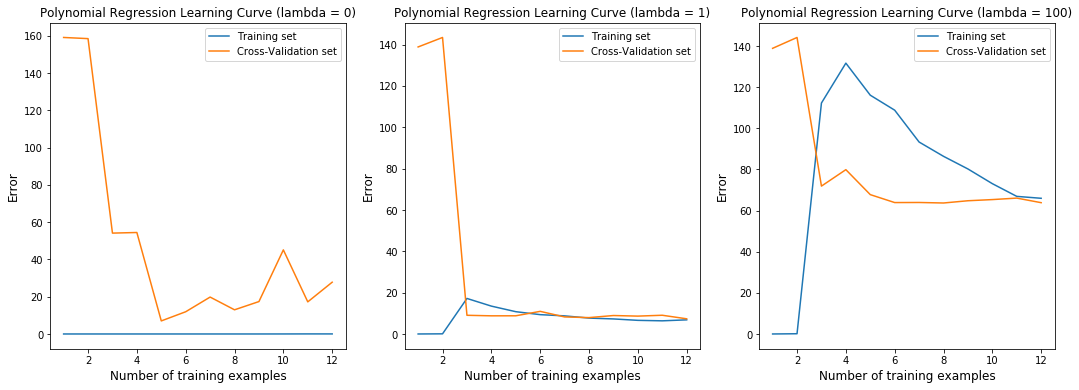

In [24]:
plotPolyLearningCurve(X_train_polyScale, y_train, X_val, y_val, lambdaConst=lambda_para)